In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import natsort.natsort as ns
import difflib
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nd2
import warnings
from skimage.measure import regionprops_table
from tqdm.auto import tqdm
from cellpose import models
from pystackreg import StackReg
from glob import glob
from sklearn.metrics import r2_score
from calcium_imaging_analysis.fig import setup_plotting_env, pal

In [3]:
def nd2_metadata_parse(img, use_metadata_timesteps=True):
    # get
    wells = []
    phase_lens = []
    with nd2.ND2File(img) as f:
        for _experiment in f.experiment:
            if _experiment.type == "NETimeLoop":
                phase_lens = [_.count for _ in _experiment.parameters.periods]
            elif _experiment.type == "XYPosLoop":
                wells = [_.name for _ in _experiment.parameters.points]
                well_scan = True
        channel_names = [_.channel.name for _ in f.metadata.channels]
        events = f.events()
        dim_sizes = dict(f.sizes)

    return_dct = {
        "dim_sizes": dim_sizes,
        "channel_names": channel_names,
        "wells": wells,
        "events": events,
    }
    return return_dct

In [4]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

colors = [(0, 0, 0), (1, 0, 0)]  # cmap goes from black (0, 0, 0) to red (1, 0, 0)
fluo_cmap = LinearSegmentedColormap.from_list("Custom", colors, N=256)

colors = [(0, 0, 0), (0, 1, 0)]  # cmap goes from black (0, 0, 0) to red (1, 0, 0)
fluo_ref_cmap = LinearSegmentedColormap.from_list("Custom", colors, N=256)

In [5]:
fig_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/panels/2025-05 (ScarCaMP paper)/"
os.makedirs(fig_dir, exist_ok=True)

input_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/red_calcium_screen/for_paper/invitro_titration/"

In [6]:
label_cmap = ListedColormap(np.random.rand(50, 3))
label_cmap.set_bad([0, 0, 0])

In [7]:
model_eval_kwargs = {"diameter": 80, "cellprob_threshold": 0.9, "channels": [[0, 0]]}

In [8]:
channel_possibilites = ["fitc", "tritc"]

regexes = {
    "calcium": r"\_C[a]*([0-9|\.]+)\_",
    "time": r"\_([0-9]+)min\_",
    "channel": r"\_([A-Z|a-z]+)\.nd2",
    "well": r"^([a-z|A-Z]\.[0-9]+)\`_",
}
regexes = {k: re.compile(_re) for k, _re in regexes.items()}

In [9]:
chk_dirs = ns.natsorted(
    [os.path.join(input_dir, _obj) for _obj in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, _obj))]
)

In [10]:
chk_dirs = chk_dirs[-2:]

In [11]:
for _chk_dir in tqdm(chk_dirs):

    nd2s = glob(os.path.join(_chk_dir, "*.nd2"))
    try:
        wells = [regexes["well"].search(os.path.basename(_nd2)).groups(0)[0] for _nd2 in nd2s]
    except AttributeError:
        print(f"No wells found in {_chk_dir} continuing...")
        continue

    uniq_wells = ns.natsorted(list(set(wells)))

    for _chk_well in tqdm(uniq_wells):
        parquet_fname = os.path.join(_chk_dir, f"{_chk_well}.parquet")

        if os.path.exists(parquet_fname):
            print(f"{parquet_fname} already exists, continuing")
            continue

        files = [_nd2 for _nd2, _well in zip(nd2s, wells) if _well == _chk_well]
        base_files = [os.path.basename(_file) for _file in files]

        all_metadata = []
        for i, _file in enumerate(files):
            base_file = os.path.basename(_file)
            # get metadata
            metadata = {}
            metadata["path"] = _file
            for k, v in regexes.items():
                metadata[k] = v.search(base_file).groups(0)[0]
                try:
                    metadata[k] = float(metadata[k])
                except ValueError:
                    pass
            metadata["channel"] = difflib.get_close_matches(metadata["channel"].lower(), channel_possibilites)[
                0
            ].upper()
            all_metadata.append(metadata)

        metadata = nd2_metadata_parse(files[0])

        # format this into some kind of ndarray to make this simpler...
        uniq_times = np.unique([_mdata["time"] for _mdata in all_metadata])
        uniq_ca = np.unique([_mdata["calcium"] for _mdata in all_metadata])
        uniq_channels = np.unique([_mdata["channel"] for _mdata in all_metadata])

        im_arr = np.full(
            (
                len(uniq_ca),
                len(uniq_times),
                len(uniq_channels),
                metadata["dim_sizes"]["Y"],
                metadata["dim_sizes"]["X"],
            ),
            fill_value=np.nan,
        )

        arrays = []
        for _mdata in tqdm(all_metadata):
            with nd2.ND2File(_mdata["path"]) as f:
                arr = f.asarray()
            # get the index...
            ca_index = np.flatnonzero(uniq_ca == _mdata["calcium"])[0]
            t_index = np.flatnonzero(uniq_times == _mdata["time"])[0]
            ch_index = np.flatnonzero(uniq_channels == _mdata["channel"])[0]

            im_arr[ca_index, t_index, ch_index, ...] = arr

        use_timepoint = []
        for i in range(len(uniq_ca)):
            # count backwards
            for j in range(len(uniq_times)):
                if ~np.isnan(im_arr[i, -j, 0, 0, 0]):
                    break
            use_timepoint.append(-j)

        new_arr = np.full(
            (
                len(uniq_ca),
                len(uniq_channels),
                metadata["dim_sizes"]["Y"],
                metadata["dim_sizes"]["X"],
            ),
            fill_value=np.nan,
        )

        for i in tqdm(range(len(uniq_ca))):
            new_arr[i] = im_arr[i, use_timepoint[i]]

        # Motion Correct if needed

        tf = StackReg.AFFINE
        sr = StackReg(tf)
        tmats = sr.register_stack(
            new_arr[:, 0].copy(),
            axis=0,
            reference="previous",
            verbose=True,
        )
        corrected_arr = new_arr.copy()
        for i in tqdm(range(len(uniq_channels))):
            corrected_arr[:, i] = sr.transform_stack(corrected_arr[:, i])

        max_proj = np.max(corrected_arr[:, uniq_channels == "FITC"], axis=0)

        model = models.Cellpose(model_type="cyto2")
        masks, _, _, _ = model.eval(max_proj, **model_eval_kwargs)

        aves = []
        divs = []
        for i in tqdm(range(len(uniq_ca))):
            dat_channel = corrected_arr[i, uniq_channels == "TRITC"].squeeze()
            ref_channel = corrected_arr[i, uniq_channels == "FITC"].squeeze()

            cell_aves = regionprops_table(masks, intensity_image=dat_channel, properties=["mean_intensity"])[
                "mean_intensity"
            ]
            aves.append(cell_aves)

            try:
                cell_aves_ref = regionprops_table(masks, intensity_image=ref_channel, properties=["mean_intensity"])[
                    "mean_intensity"
                ]
                divs.append(cell_aves_ref)
                # print(np.median(cell_aves / (cell_aves_ref + 50)))
            except (ValueError, KeyError):
                pass

        if len(aves) == 0:
            continue

        aves = np.array(aves)
        divs = np.array(divs)

        if len(divs) == 0:
            divs = aves.copy()
            divs[:] = np.nan

        ave_df = pd.DataFrame(aves).melt(ignore_index=False, var_name="roi", value_name="TRITC")
        div_df = pd.DataFrame(divs).melt(ignore_index=False, var_name="roi", value_name="FITC")

        ave_df.index.name = "ca_condition"
        div_df.index.name = "ca_condition"

        ave_df["FITC"] = div_df["FITC"]

        ave_df["well"] = _chk_well
        ave_df = ave_df.reset_index()
        ave_df.to_parquet(parquet_fname)

  0%|          | 0/2 [00:00<?, ?it/s]

No wells found in /storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/red_calcium_screen/for_paper/invitro_titration/2025-03-21 Ca titration continuing...
No wells found in /storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/red_calcium_screen/for_paper/invitro_titration/2025-03-25 Ca titration continuing...


# Combine processed dataframes and plot...

In [12]:
x = [
    0,
    0.003751,
    0.007,
    0.01186,
    0.01625,
    0.03657,
    0.0627,
    0.0975,
    0.146,
    0.219,
    0.341,
    0.585,
    1.3,
    38.6,
]

In [13]:
load_files = []

In [14]:
for _dir in chk_dirs:
    load_files += glob(os.path.join(_dir, "[A|B].*.parquet"))

In [15]:
dfs = []
roi_count = 0
for _file in tqdm(load_files):
    _df = pd.read_parquet(_file)
    _df["roi"] += roi_count
    roi_count = _df["roi"].max()
    topdir = os.path.basename(os.path.dirname(_file))
    session = topdir.split(" ")[0]
    _df["session"] = session
    dfs.append(_df)
use_df = pd.concat(dfs, ignore_index=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
use_df["ratio"] = use_df["TRITC"] / use_df["FITC"]

In [17]:
min_fluorescence = 200
max_fitc_change_p = 0.1
max_ratio_change_p = 1
min_ratio_change_p = 0.1

In [18]:
new_df = use_df.copy()
new_df["roi_tuple"] = new_df[["session", "well", "roi"]].apply(tuple, axis=1)
new_df["roi_code"] = pd.factorize(new_df["roi_tuple"])[0]
new_df = new_df.groupby("roi_code").filter(
    lambda x: (x["TRITC"].min() > min_fluorescence) & (x["FITC"].min() > min_fluorescence)
)
new_df = new_df.groupby("roi_code").filter(
    lambda x: ((x["FITC"].max() - x["FITC"].min()) / x["FITC"].max()) < max_fitc_change_p
)
new_df = new_df.groupby("roi_code").filter(
    lambda x: ((x["ratio"].max() - x["ratio"].min()) / x["ratio"].max()) < max_ratio_change_p
)
new_df = new_df.groupby("roi_code").filter(
    lambda x: ((x["ratio"].max() - x["ratio"].min()) / x["ratio"].max()) > min_ratio_change_p
)

In [19]:
new_df["ratio_minmax"] = new_df.groupby("roi_code")["ratio"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
new_df["tritc_minmax"] = new_df.groupby("roi_code")["TRITC"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [20]:
concentration_map = {i: concentration for i, concentration in enumerate(x)}

In [21]:
new_df["ca_concentration"] = new_df["ca_condition"].map(concentration_map)

In [22]:
from scipy.optimize import least_squares

In [23]:
def hill_func(x, top, bottom, ic50, slope):
    return bottom + (top - bottom) / (np.power((x / ic50), slope) + 1)

In [24]:
# Residuals function for least squares
def residuals(params, x, y_obs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        y_pred = hill_func(x, *params)
    return y_pred - y_obs

In [25]:
def get_fit(df, x="ca_concentration", y="ratio_minmax", exclude_zero=False):

    X, Y = df[x].to_numpy(), df[y].to_numpy()
    if exclude_zero:
        excl = X == 0
        X = X[~excl]
        Y = Y[~excl]

    initial_guess = [max(Y), min(Y), np.median(X), 1.0]
    result = least_squares(residuals, initial_guess, args=(X, Y), loss="linear")
    popt = result.x
    rsquared = r2_score(hill_func(X, *popt), Y)
    params = {"top": popt[0], "bottom": popt[1], "ic50": popt[2], "hill_coef": popt[3], "r2": rsquared}
    return params

In [26]:
fit_df = new_df.groupby(["session", "well"]).filter(lambda x: x["roi"].nunique() > 10)

In [28]:
fit_df.groupby(["well", "session"])["roi"].nunique()

well  session   
A.4   2025-03-21    11
      2025-03-25    64
A.5   2025-03-21    33
B.3   2025-03-25    69
B.4   2025-03-25    77
B.5   2025-03-21    16
Name: roi, dtype: int64

In [29]:
# fit per group...
fit_results_df = fit_df.groupby(["well", "session"]).apply(get_fit, include_groups=False)
fit_results_df = fit_results_df.apply(pd.Series)

In [31]:
params_mean = fit_results_df.mean()
params_ci = fit_results_df.std()

In [32]:
latex_codes = {
    "r2": r"$\mathrm{{R}}^2$",
    "ic50": r"$\mathrm{{IC}}_{{50}}$",
    "hill_coef": r"$\mathcal{{n}}$",
    "top": r"$\mathrm{{max}}$",
    "bottom": r"$\mathrm{{min}}$",
}

In [33]:
use_string = ""
for _param in params_mean.keys():
    use_code = latex_codes[_param]
    use_string += use_code + f" = {params_mean[_param]:.3f} " + rf"$\pm$ {params_ci[_param]:.3f}"
    use_string += "\n"

In [34]:
eval_points = np.linspace(0, 60, 1000)

In [35]:
top = hill_func(eval_points, *(params_mean + params_ci).iloc[:4])
bottom = hill_func(eval_points, *(params_mean - params_ci).iloc[:4])

In [36]:
plt.rcParams["figure.dpi"] = 200

In [37]:
fit_results_df

top    bottom      ic50  hill_coef        r2
well session                                                      
A.4  2025-03-21  1.006725  0.041859  0.027315   0.876816  0.926578
     2025-03-25  1.005061  0.001987  0.024721   0.689331  0.932249
A.5  2025-03-21  0.954732  0.040269  0.021293   1.071891  0.860690
B.3  2025-03-25  0.992305 -0.052320  0.046374   0.449132  0.774896
B.4  2025-03-25  0.955862 -0.031061  0.078942   0.723580  0.929919
B.5  2025-03-21  0.886157  0.075128  0.051635   1.385553  0.877704

In [38]:
params_mean

top          0.966807
bottom       0.012644
ic50         0.041713
hill_coef    0.866051
r2           0.883673
dtype: float64

In [39]:
setup_plotting_env()

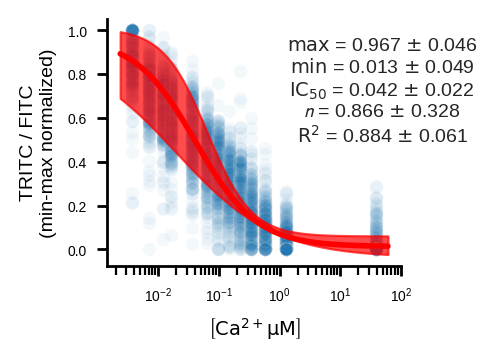

In [40]:
fig, ax = plt.subplots(1, figsize=(1.9, 1.6))
sns.scatterplot(
    data=new_df,
    # hue="session",
    x="ca_concentration",
    y="ratio_minmax",
    alpha=0.05,
)
ax.set_xlabel(r"$\left[\mathrm{Ca}^{2+} \mathrm{µM}\right]$")
ax.set_ylabel("TRITC / FITC\n(min-max normalized)")
ax.set_xscale("log")

xlims = ax.get_xlim()
xlims_log = [np.log10(_xlim) for _xlim in xlims]
# eval_points = np.linspace(*xlims, int(1e6))
eval_points = np.logspace(*xlims_log, 500)
top = hill_func(eval_points, *(params_mean + params_ci).iloc[:4])
bottom = hill_func(eval_points, *(params_mean - params_ci).iloc[:4])
ax.fill_between(eval_points, top, bottom, alpha=0.7, color="r")
ax.plot(eval_points, hill_func(eval_points, *params_mean.iloc[:4].values), "r-", marker=None, lw=2)

ylims = ax.get_ylim()
xrange = xlims[1] - xlims[0]
yrange = ylims[1] - ylims[0]
xpos = xlims[1] - xrange / 5
ypos = ylims[1] - yrange / 3
ax.text(xpos, ypos, use_string, ha="center", va="center", fontsize=7)
sns.despine()
fig.savefig(os.path.join(fig_dir, "digitonin_results_with_fit.pdf"), dpi=600, bbox_inches="tight")